# 🏎️ Model v3 1B : Random Forest - Position Regression

**Goal:** Predict exact finishing position (1-20) using Random Forest Regression

**Improvements Applied:**
1.  Conservative baseline to prevent overfitting
2.  Learning curve analysis
3.  Careful hyperparameter optimization
4.  Position-specific error analysis
5.  Feature importance with permutation
6.  Prediction interval analysis
7.  Residual analysis by race conditions

## STEP 1 : Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    RandomizedSearchCV, 
    KFold,
    learning_curve
)
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    make_scorer
)
from sklearn.inspection import permutation_importance

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("All libraries imported successfully!")

All libraries imported successfully!


## Step 2 : Loading data

In [2]:
print(" Loading processed data...")


train_df = pd.read_parquet('../../../data/processed/train_data_v3.parquet')
test_df = pd.read_parquet('../../../data/processed/test_data_v3.parquet')


train_weights = np.load('../../../data/processed/train_weights_v3.npy')
test_weights = np.load('../../../data/processed/test_weights_v3.npy')


with open('../../../data/processed/metadata_v3.json', 'r') as f:
    metadata = json.load(f)

print(f"\n✅ Data loaded successfully!")
print(f"   Training samples: {len(train_df)} (2024 season)")
print(f"   Test samples: {len(test_df)} (2025 season)")
print(f"   Features: {len(metadata['feature_columns'])}")

 Loading processed data...

✅ Data loaded successfully!
   Training samples: 1314 (2024 season)
   Test samples: 385 (2025 season)
   Features: 74


## Step 3 : Preparing Features and Targets

In [3]:
feature_cols = metadata['feature_columns']
target = 'position'

X_train = train_df[feature_cols]
X_test = test_df[feature_cols]

y_train = train_df[target]
y_test = test_df[target]

X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]
feature_cols = X_train.columns.tolist()

print(f"\n Data prepared for regression!")
print(f"   Features shape: {X_train.shape}")
print(f"\n Position Distribution (Training):")
print(f"   Mean: {y_train.mean():.2f}")
print(f"   Std:  {y_train.std():.2f}")
print(f"   Min:  {y_train.min():.0f}")
print(f"   Max:  {y_train.max():.0f}")
print(f"   Median: {y_train.median():.0f}")


position_counts = y_train.value_counts().sort_index()
print(f"\n📈 Position Frequency:")
for pos in [1, 2, 3, 10, 20]:
    if pos in position_counts.index:
        print(f"   P{pos:2d}: {position_counts[pos]:3d} occurrences ({position_counts[pos]/len(y_train)*100:.1f}%)")


 Data prepared for regression!
   Features shape: (1314, 69)

 Position Distribution (Training):
   Mean: 10.44
   Std:  5.81
   Min:  1
   Max:  20
   Median: 10

📈 Position Frequency:
   P 1:  68 occurrences (5.2%)
   P 2:  68 occurrences (5.2%)
   P 3:  68 occurrences (5.2%)
   P10:  63 occurrences (4.8%)
   P20:  66 occurrences (5.0%)


## Step 4 : Define Evaluation Fucntions

In [4]:
def calculate_regression_metrics(y_true,y_pred,weights = None):

    mae = mean_absolute_error(y_true,y_pred,sample_weight = weights)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred, sample_weight=weights))
    r2 = r2_score(y_true,y_pred,sample_weight = weights)

    errors = np.abs(y_true - y_pred)
    within_1 = np.mean(errors <= 1)*100
    within_2 = np.mean(errors <= 2)*100
    within_3 = np.mean(errors <= 3)*100
    within_5 = np.mean(errors <= 5)*100

    median_ae = np.median(errors)
    max_error = np.max(errors)

    return{
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Median_AE': median_ae,
        'Max_Error': max_error,
        'Within_1': within_1,
        'Within_2': within_2,
        'Within_3': within_3,
        'Within_5': within_5
    }


def print_regression_metrics(metrics, dataset_name = "Dataset"):

    print(f"\n{'='*70}")
    print(f"📊 {dataset_name.upper()}")
    print(f"{'='*70}")
    print(f"   MAE (Mean Absolute Error):     {metrics['MAE']:.3f} positions")
    print(f"   RMSE (Root Mean Squared Error): {metrics['RMSE']:.3f} positions")
    print(f"   R² Score:                       {metrics['R2']:.3f}")
    print(f"   Median Absolute Error:          {metrics['Median_AE']:.3f} positions")
    print(f"   Maximum Error:                  {metrics['Max_Error']:.1f} positions")
    print(f"\n🎯 PREDICTION ACCURACY:")
    print(f"   Within 1 position:  {metrics['Within_1']:.1f}%")
    print(f"   Within 2 positions: {metrics['Within_2']:.1f}%")
    print(f"   Within 3 positions: {metrics['Within_3']:.1f}%")
    print(f"   Within 5 positions: {metrics['Within_5']:.1f}%")
    print(f"{'='*70}")


def plot_learning_curve(model,X,y,weights = None,cv=5,title="Learning Curve"):

    print(f"\n Generating learning curve for: {title}")

    fit_params = {'sample_weight' : weights} if weights is not None else None

    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=cv,
        n_jobs=-1,
        scoring='neg_mean_absolute_error',
        verbose=0,
        fit_params = fit_params
    )

    train_mean = -np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = -np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training MAE', color='#3671C6', marker='o', linewidth=2)
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='#3671C6')
    plt.plot(train_sizes, val_mean, label='CV MAE', color='#E10600', marker='s', linewidth=2)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='#E10600')
    plt.xlabel('Training Set Size', fontsize=12, fontweight='bold')
    plt.ylabel('MAE (positions)', fontsize=12, fontweight='bold')
    plt.title(title, fontweight='bold', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    
    
    final_gap = val_mean[-1] - train_mean[-1]
    plt.text(0.02, 0.98, f'Final Train-Val Gap: {final_gap:.3f}', 
             transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    print(f"   ✅ Final Training MAE: {train_mean[-1]:.3f}")
    print(f"   ✅ Final CV MAE: {val_mean[-1]:.3f}")
    print(f"   📊 Overfitting gap: {final_gap:.3f}")
    
    return train_mean, val_mean


def analyze_position_errors(y_true, y_pred, title="Position Error Analysis"):
    
    errors = np.abs(y_true - y_pred)
    df = pd.DataFrame({'actual_position': y_true, 'error': errors})
    
    position_errors = df.groupby('actual_position')['error'].agg(['mean', 'std', 'count'])
    
    print(f"\n📊 {title}:")
    print(f"{'Position':<10} {'Mean Error':<12} {'Std Error':<12} {'Count':<8}")
    print("-" * 50)
    for pos in sorted(position_errors.index):
        mean_err = position_errors.loc[pos, 'mean']
        std_err = position_errors.loc[pos, 'std']
        count = position_errors.loc[pos, 'count']
        print(f"P{pos:<9.0f} {mean_err:<12.3f} {std_err:<12.3f} {count:<8.0f}")
    
    return position_errors

print("✅ Evaluation functions defined!")

✅ Evaluation functions defined!


## Step 5 : Train conservative baseline model

In [5]:
baseline_params = {
    'n_estimators': 200,
    'max_depth': 15,        # Moderate depth
    'min_samples_split': 20, # Higher constraint
    'min_samples_leaf': 10,  # Higher constraint
    'max_features': 'sqrt',
    'max_samples': 0.8,      # Bootstrap with 80%
    'random_state': 42,
    'n_jobs': -1
}

print("\n Conservative Baseline Parameters:")
for param, value in baseline_params.items():
    if param not in ['random_state', 'n_jobs']:
        print(f"   {param}: {value}")

print("\n  Training baseline model...")

baseline_model = RandomForestRegressor(**baseline_params)
baseline_model.fit(X_train, y_train, sample_weight=train_weights)

print("\n✅ Baseline model trained!")


baseline_train_pred = baseline_model.predict(X_train)
baseline_test_pred = baseline_model.predict(X_test)


baseline_train_metrics = calculate_regression_metrics(y_train, baseline_train_pred, train_weights)
baseline_test_metrics = calculate_regression_metrics(y_test, baseline_test_pred, test_weights)

print_regression_metrics(baseline_train_metrics, "Baseline Training")
print_regression_metrics(baseline_test_metrics, "Baseline Test (2025)")


baseline_results = {
    'model': baseline_model,
    'params': baseline_params,
    'train_metrics': baseline_train_metrics,
    'test_metrics': baseline_test_metrics,
    'train_pred': baseline_train_pred,
    'test_pred': baseline_test_pred
}


baseline_position_errors = analyze_position_errors(
    y_test, baseline_test_pred, "Baseline Position Errors"
)

print(f"\n Key Insight: Test MAE = {baseline_test_metrics['MAE']:.3f} positions")        


 Conservative Baseline Parameters:
   n_estimators: 200
   max_depth: 15
   min_samples_split: 20
   min_samples_leaf: 10
   max_features: sqrt
   max_samples: 0.8

  Training baseline model...

✅ Baseline model trained!

📊 BASELINE TRAINING
   MAE (Mean Absolute Error):     2.337 positions
   RMSE (Root Mean Squared Error): 3.183 positions
   R² Score:                       0.700
   Median Absolute Error:          2.244 positions
   Maximum Error:                  17.0 positions

🎯 PREDICTION ACCURACY:
   Within 1 position:  23.4%
   Within 2 positions: 45.2%
   Within 3 positions: 63.9%
   Within 5 positions: 86.2%

📊 BASELINE TEST (2025)
   MAE (Mean Absolute Error):     3.217 positions
   RMSE (Root Mean Squared Error): 4.184 positions
   R² Score:                       0.467
   Median Absolute Error:          2.414 positions
   Maximum Error:                  13.9 positions

🎯 PREDICTION ACCURACY:
   Within 1 position:  17.7%
   Within 2 positions: 40.0%
   Within 3 positions: 59

## Step 6 : Learning Curve Analysis


 Generating learning curve for: Learning Curve - Baseline Regression Model


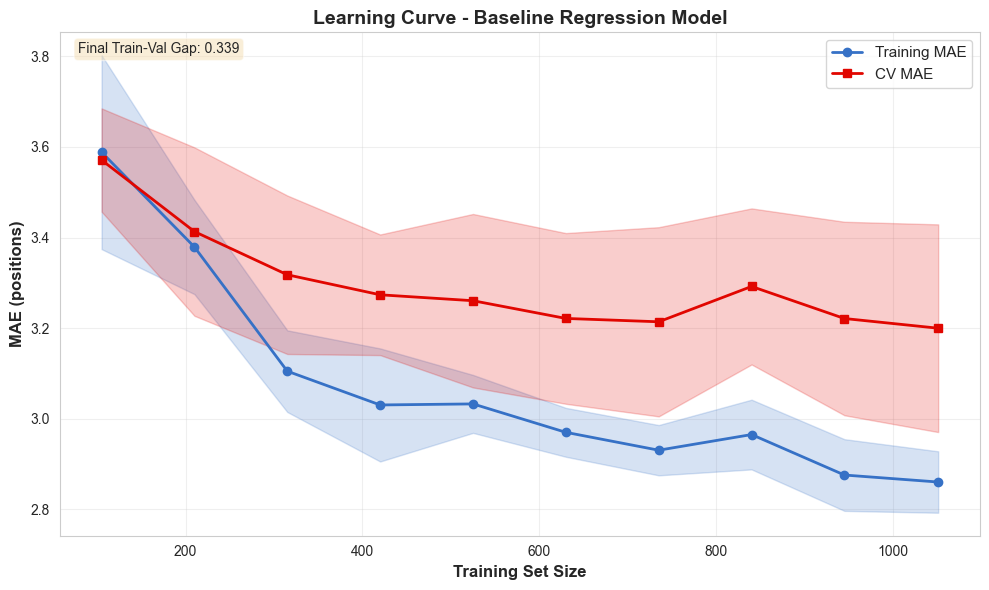

   ✅ Final Training MAE: 2.861
   ✅ Final CV MAE: 3.200
   📊 Overfitting gap: 0.339

 Good! Acceptable generalization.


In [6]:
baseline_train_lc, baseline_val_lc = plot_learning_curve(
    baseline_model,
    X_train,
    y_train,
    weights=train_weights,
    cv=5,
    title="Learning Curve - Baseline Regression Model"
)


overfitting_gap = baseline_val_lc[-1] - baseline_train_lc[-1]
if overfitting_gap < 0.3:
    print("\n Excellent! Minimal overfitting detected.")
elif overfitting_gap < 0.5:
    print("\n Good! Acceptable generalization.")
else:
    print("\n  Warning: Model may be overfitting. Hyperparameter tuning needed.")

## Step 7 : Hyperparamter Optimization

In [7]:
param_grid = {
    'n_estimators': [150, 200, 250, 300],
    'max_depth': [12, 15, 18, 20],        # Moderate depths
    'min_samples_split': [15, 20, 25, 30], # Higher values
    'min_samples_leaf': [8, 10, 12, 15],   # Higher values
    'max_features': ['sqrt', 'log2', 0.4, 0.5, 0.6],
    'max_samples': [0.7, 0.8, 0.9],
    'bootstrap': [True]
}

print("\n Conservative Search Space:")
print(f"   n_estimators: {param_grid['n_estimators']}")
print(f"   max_depth: {param_grid['max_depth']} (moderate)")
print(f"   min_samples_split: {param_grid['min_samples_split']} (higher)")
print(f"   min_samples_leaf: {param_grid['min_samples_leaf']} (higher)")
print(f"   max_features: {param_grid['max_features']}")

print(f"\n Starting RandomizedSearchCV...")
print(f"   Iterations: 40 random combinations")
print(f"   CV Folds: 5")
print(f"   Scoring: Negative MAE (weighted)")


weighted_mae_scorer = make_scorer(
    mean_absolute_error,
    greater_is_better=False
)

kfold_cv = KFold(n_splits = 5, shuffle = True,random_state = 42)

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_grid,
    n_iter=40,
    scoring=weighted_mae_scorer,
    cv=kfold_cv,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)


print("🚀 Starting optimization...\n")
random_search.fit(X_train, y_train,sample_weight = train_weights)

print("\n Hyperparameter search complete!")
print(f"   Best CV MAE: {-random_search.best_score_:.3f}")


optimized_model = random_search.best_estimator_
best_params = random_search.best_params_

print("\n🏆 Best Parameters Found:")
for param, value in sorted(best_params.items()):
    print(f"   {param}: {value}")

print("\n🔄 Parameter Changes from Baseline:")
for param in baseline_params.keys():
    if param in best_params and param not in ['random_state', 'n_jobs']:
        baseline_val = baseline_params[param]
        best_val = best_params[param]
        if baseline_val != best_val:
            print(f"   {param}: {baseline_val} → {best_val}")


 Conservative Search Space:
   n_estimators: [150, 200, 250, 300]
   max_depth: [12, 15, 18, 20] (moderate)
   min_samples_split: [15, 20, 25, 30] (higher)
   min_samples_leaf: [8, 10, 12, 15] (higher)
   max_features: ['sqrt', 'log2', 0.4, 0.5, 0.6]

 Starting RandomizedSearchCV...
   Iterations: 40 random combinations
   CV Folds: 5
   Scoring: Negative MAE (weighted)
🚀 Starting optimization...

Fitting 5 folds for each of 40 candidates, totalling 200 fits

 Hyperparameter search complete!
   Best CV MAE: 2.935

🏆 Best Parameters Found:
   bootstrap: True
   max_depth: 12
   max_features: 0.6
   max_samples: 0.8
   min_samples_leaf: 15
   min_samples_split: 30
   n_estimators: 200

🔄 Parameter Changes from Baseline:
   max_depth: 15 → 12
   min_samples_split: 20 → 30
   min_samples_leaf: 10 → 15
   max_features: sqrt → 0.6


## Step 8 : Evaluate Optimized Model

In [8]:
print("\n🔮 Making predictions with optimized model...")


optimized_train_pred = optimized_model.predict(X_train)
optimized_test_pred = optimized_model.predict(X_test)


optimized_train_metrics = calculate_regression_metrics(y_train, optimized_train_pred, train_weights)
optimized_test_metrics = calculate_regression_metrics(y_test, optimized_test_pred, test_weights)

print_regression_metrics(optimized_train_metrics, "Optimized Training")
print_regression_metrics(optimized_test_metrics, "Optimized Test (2025)")


optimized_results = {
    'model': optimized_model,
    'params': best_params,
    'train_metrics': optimized_train_metrics,
    'test_metrics': optimized_test_metrics,
    'train_pred': optimized_train_pred,
    'test_pred': optimized_test_pred,
    'cv_results': pd.DataFrame(random_search.cv_results_)
}


optimized_position_errors = analyze_position_errors(
    y_test, optimized_test_pred, "Optimized Position Errors"
)


🔮 Making predictions with optimized model...

📊 OPTIMIZED TRAINING
   MAE (Mean Absolute Error):     2.269 positions
   RMSE (Root Mean Squared Error): 3.138 positions
   R² Score:                       0.709
   Median Absolute Error:          2.111 positions
   Maximum Error:                  17.7 positions

🎯 PREDICTION ACCURACY:
   Within 1 position:  23.4%
   Within 2 positions: 48.5%
   Within 3 positions: 65.8%
   Within 5 positions: 86.5%

📊 OPTIMIZED TEST (2025)
   MAE (Mean Absolute Error):     3.191 positions
   RMSE (Root Mean Squared Error): 4.175 positions
   R² Score:                       0.469
   Median Absolute Error:          2.346 positions
   Maximum Error:                  13.6 positions

🎯 PREDICTION ACCURACY:
   Within 1 position:  17.1%
   Within 2 positions: 41.3%
   Within 3 positions: 61.3%
   Within 5 positions: 81.8%

📊 Optimized Position Errors:
Position   Mean Error   Std Error    Count   
--------------------------------------------------
P1         2.4

## Step 9 : Comparision

In [9]:
comparison_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R²', 'Median_AE', 'Within_1', 'Within_2', 'Within_3', 'Within_5'],
    'Baseline_Train': [
        baseline_train_metrics['MAE'],
        baseline_train_metrics['RMSE'],
        baseline_train_metrics['R2'],
        baseline_train_metrics['Median_AE'],
        baseline_train_metrics['Within_1'],
        baseline_train_metrics['Within_2'],
        baseline_train_metrics['Within_3'],
        baseline_train_metrics['Within_5']
    ],
    'Baseline_Test': [
        baseline_test_metrics['MAE'],
        baseline_test_metrics['RMSE'],
        baseline_test_metrics['R2'],
        baseline_test_metrics['Median_AE'],
        baseline_test_metrics['Within_1'],
        baseline_test_metrics['Within_2'],
        baseline_test_metrics['Within_3'],
        baseline_test_metrics['Within_5']
    ],
    'Optimized_Train': [
        optimized_train_metrics['MAE'],
        optimized_train_metrics['RMSE'],
        optimized_train_metrics['R2'],
        optimized_train_metrics['Median_AE'],
        optimized_train_metrics['Within_1'],
        optimized_train_metrics['Within_2'],
        optimized_train_metrics['Within_3'],
        optimized_train_metrics['Within_5']
    ],
    'Optimized_Test': [
        optimized_test_metrics['MAE'],
        optimized_test_metrics['RMSE'],
        optimized_test_metrics['R2'],
        optimized_test_metrics['Median_AE'],
        optimized_test_metrics['Within_1'],
        optimized_test_metrics['Within_2'],
        optimized_test_metrics['Within_3'],
        optimized_test_metrics['Within_5']
    ]
})

print("\n Detailed Comparison:")
display(comparison_df)

# Calculate improvements
mae_improvement = ((baseline_test_metrics['MAE'] - optimized_test_metrics['MAE']) / 
                   baseline_test_metrics['MAE'] * 100)
r2_improvement = ((optimized_test_metrics['R2'] - baseline_test_metrics['R2']) / 
                  abs(baseline_test_metrics['R2']) * 100)
within2_improvement = optimized_test_metrics['Within_2'] - baseline_test_metrics['Within_2']

print(f"\n TEST SET IMPROVEMENTS:")
print(f"   MAE:      {baseline_test_metrics['MAE']:.3f} → {optimized_test_metrics['MAE']:.3f} "
      f"({mae_improvement:+.1f}%)")
print(f"   R²:       {baseline_test_metrics['R2']:.3f} → {optimized_test_metrics['R2']:.3f} "
      f"({r2_improvement:+.1f}%)")
print(f"   Within 2: {baseline_test_metrics['Within_2']:.1f}% → {optimized_test_metrics['Within_2']:.1f}% "
      f"({within2_improvement:+.1f} pp)")

if optimized_test_metrics['MAE'] < baseline_test_metrics['MAE']:
    print(f"\n✅ OPTIMIZATION SUCCESSFUL! Test MAE improved by {mae_improvement:.1f}%")
    best_model_name = "Optimized"
    best_model = optimized_model
    best_results = optimized_results
else:
    print(f"\n  Baseline performed better. Using baseline model.")
    best_model_name = "Baseline"
    best_model = baseline_model
    best_results = baseline_results

print(f"\n Best Model: {best_model_name} (MAE: {best_results['test_metrics']['MAE']:.3f})")


 Detailed Comparison:


,Metric,Baseline_Train,Baseline_Test,Optimized_Train,Optimized_Test
0,MAE,2.337370,3.216768,2.269222,3.190938
1,RMSE,3.183486,4.184019,3.138254,4.175171
2,R²,0.700227,0.467174,0.708685,0.469425
3,Median_AE,2.243897,2.414357,2.111087,2.346316
4,Within_1,23.363775,17.662338,23.439878,17.142857
5,Within_2,45.205479,40.000000,48.477930,41.298701
6,Within_3,63.926941,59.740260,65.829528,61.298701
7,Within_5,86.225266,81.298701,86.453577,81.818182



 TEST SET IMPROVEMENTS:
   MAE:      3.217 → 3.191 (+0.8%)
   R²:       0.467 → 0.469 (+0.5%)
   Within 2: 40.0% → 41.3% (+1.3 pp)

✅ OPTIMIZATION SUCCESSFUL! Test MAE improved by 0.8%

 Best Model: Optimized (MAE: 3.191)


## Step 10 : Vizuallizations

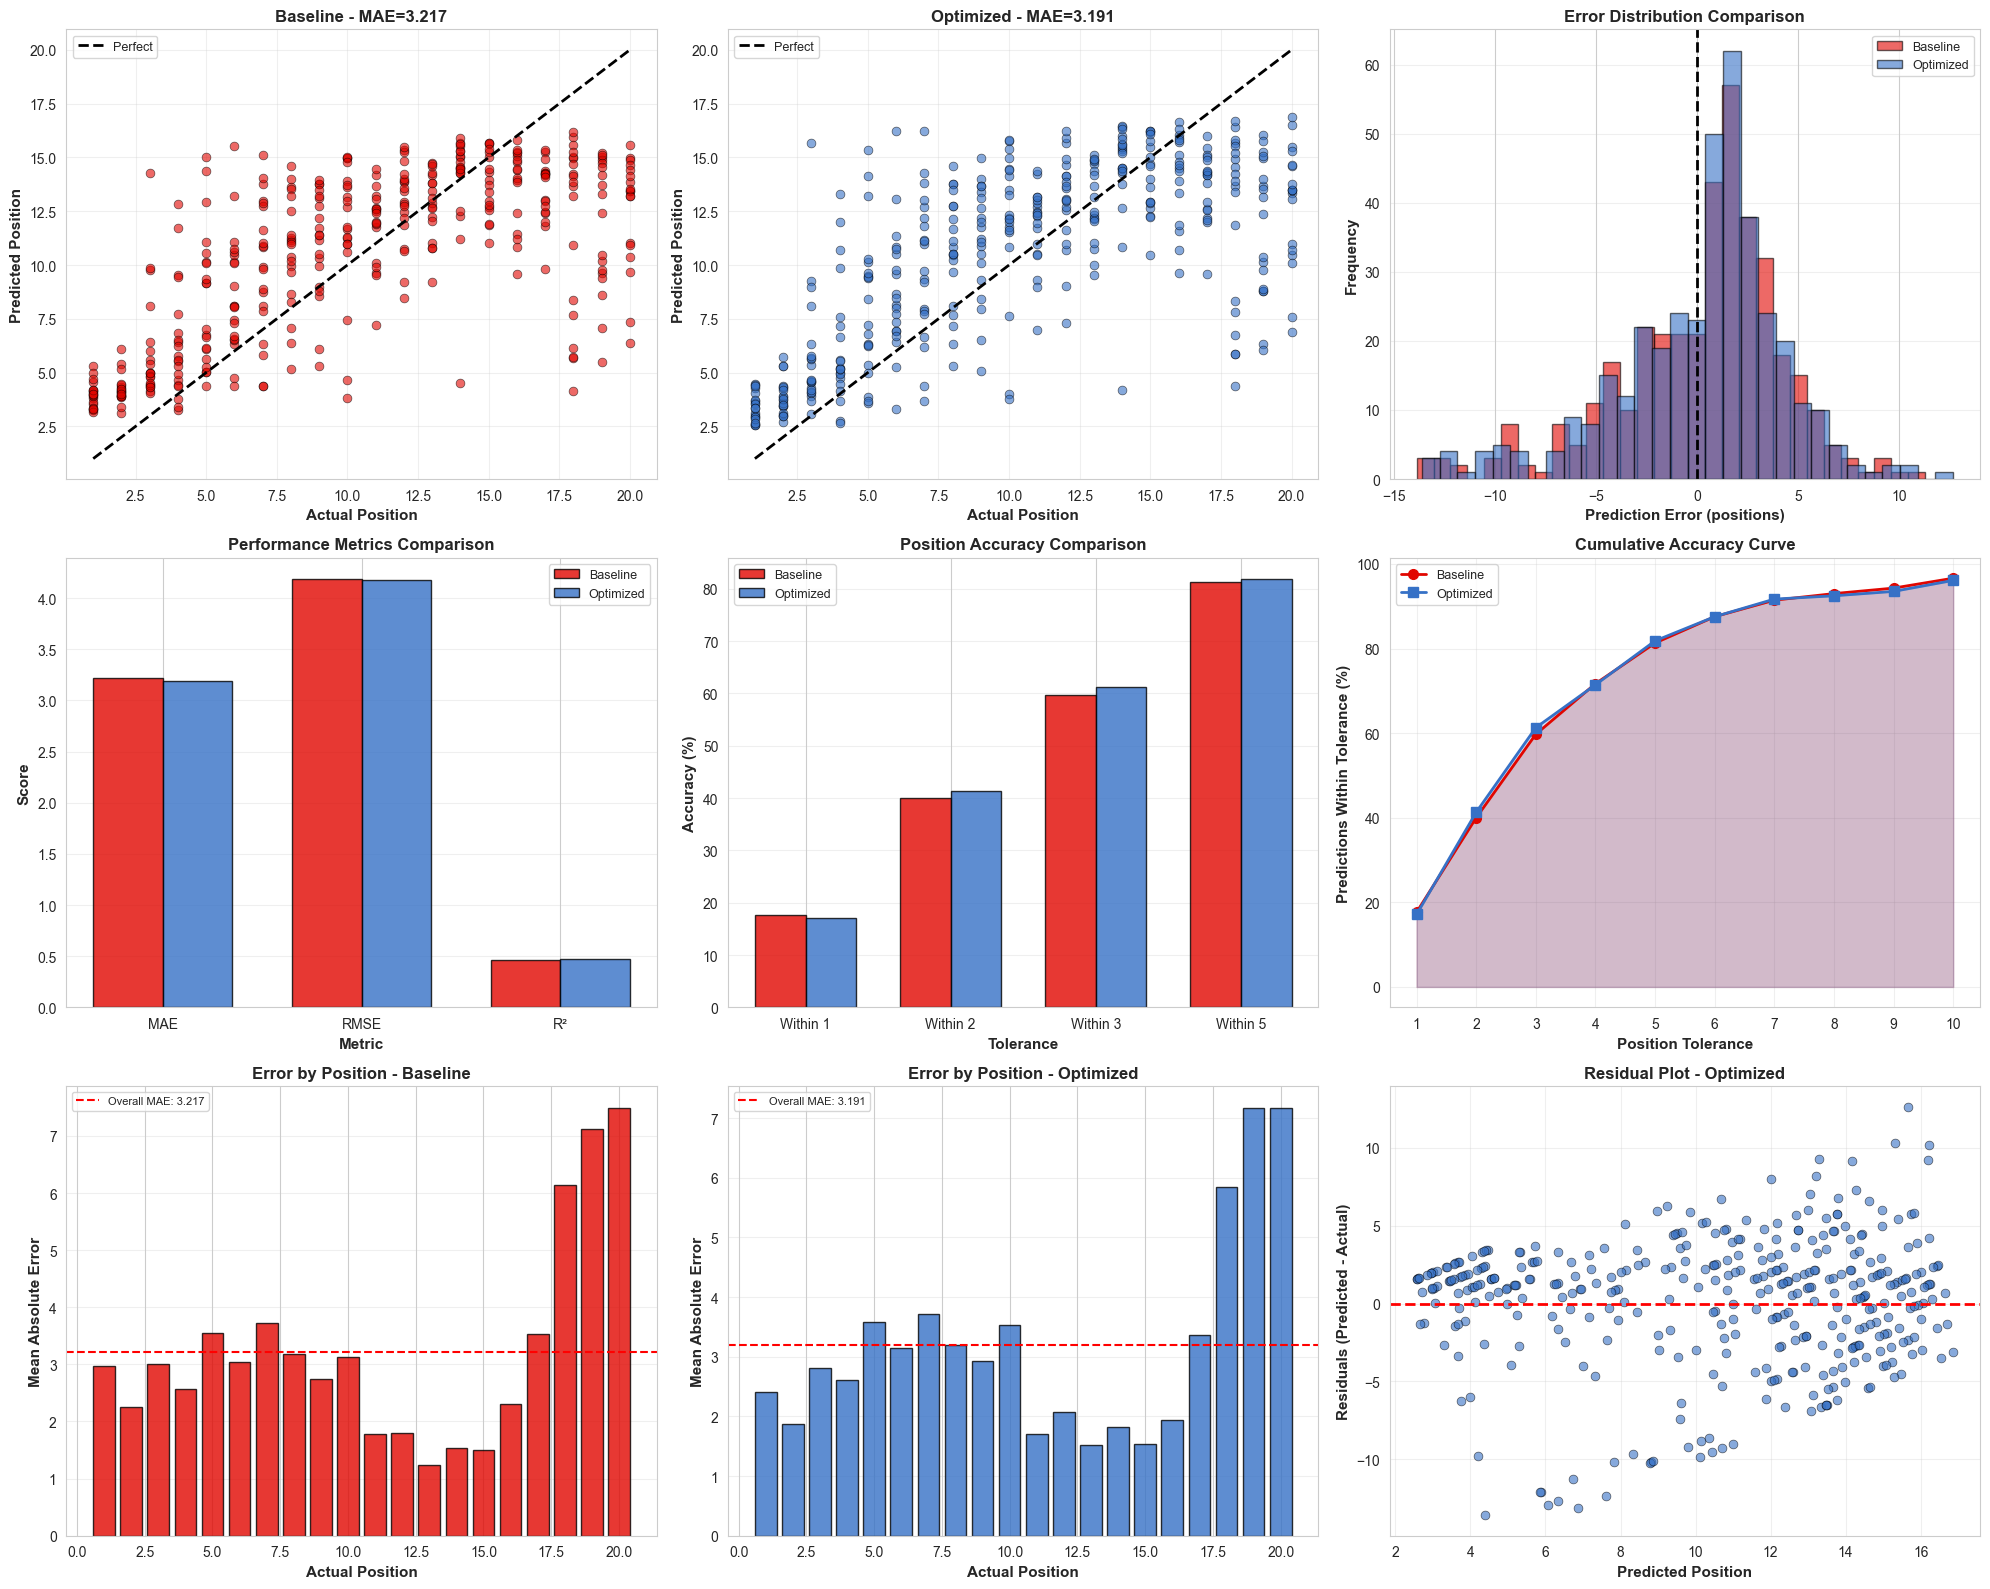

✅ Detailed visualizations complete!


In [10]:
fig, axes = plt.subplots(3, 3, figsize=(20, 16))


axes[0, 0].scatter(y_test, baseline_test_pred, alpha=0.6, s=40, color='#E10600', edgecolors='black', linewidth=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect')
axes[0, 0].set_xlabel('Actual Position', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Predicted Position', fontsize=11, fontweight='bold')
axes[0, 0].set_title(f'Baseline - MAE={baseline_test_metrics["MAE"]:.3f}', fontweight='bold', fontsize=12)
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(alpha=0.3)


axes[0, 1].scatter(y_test, optimized_test_pred, alpha=0.6, s=40, color='#3671C6', edgecolors='black', linewidth=0.5)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect')
axes[0, 1].set_xlabel('Actual Position', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Predicted Position', fontsize=11, fontweight='bold')
axes[0, 1].set_title(f'Optimized - MAE={optimized_test_metrics["MAE"]:.3f}', fontweight='bold', fontsize=12)
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(alpha=0.3)


residuals_baseline = baseline_test_pred - y_test
residuals_optimized = optimized_test_pred - y_test

axes[0, 2].hist(residuals_baseline, bins=30, alpha=0.6, color='#E10600', label='Baseline', edgecolor='black')
axes[0, 2].hist(residuals_optimized, bins=30, alpha=0.6, color='#3671C6', label='Optimized', edgecolor='black')
axes[0, 2].axvline(0, color='black', linestyle='--', lw=2)
axes[0, 2].set_xlabel('Prediction Error (positions)', fontsize=11, fontweight='bold')
axes[0, 2].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 2].set_title('Error Distribution Comparison', fontweight='bold', fontsize=12)
axes[0, 2].legend(fontsize=9)
axes[0, 2].grid(axis='y', alpha=0.3)


metrics = ['MAE', 'RMSE', 'R²']
baseline_vals = [baseline_test_metrics['MAE'], baseline_test_metrics['RMSE'], baseline_test_metrics['R2']]
optimized_vals = [optimized_test_metrics['MAE'], optimized_test_metrics['RMSE'], optimized_test_metrics['R2']]

x = np.arange(len(metrics))
width = 0.35

axes[1, 0].bar(x - width/2, baseline_vals, width, label='Baseline', color='#E10600', alpha=0.8, edgecolor='black')
axes[1, 0].bar(x + width/2, optimized_vals, width, label='Optimized', color='#3671C6', alpha=0.8, edgecolor='black')
axes[1, 0].set_xlabel('Metric', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Score', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Performance Metrics Comparison', fontweight='bold', fontsize=12)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metrics)
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(axis='y', alpha=0.3)


accuracy_metrics = ['Within 1', 'Within 2', 'Within 3', 'Within 5']
baseline_acc = [baseline_test_metrics['Within_1'], baseline_test_metrics['Within_2'], 
                baseline_test_metrics['Within_3'], baseline_test_metrics['Within_5']]
optimized_acc = [optimized_test_metrics['Within_1'], optimized_test_metrics['Within_2'], 
                 optimized_test_metrics['Within_3'], optimized_test_metrics['Within_5']]

x = np.arange(len(accuracy_metrics))
axes[1, 1].bar(x - width/2, baseline_acc, width, label='Baseline', color='#E10600', alpha=0.8, edgecolor='black')
axes[1, 1].bar(x + width/2, optimized_acc, width, label='Optimized', color='#3671C6', alpha=0.8, edgecolor='black')
axes[1, 1].set_xlabel('Tolerance', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Position Accuracy Comparison', fontweight='bold', fontsize=12)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(accuracy_metrics)
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(axis='y', alpha=0.3)


errors_baseline = np.abs(residuals_baseline)
errors_optimized = np.abs(residuals_optimized)
positions = range(1, 11)
within_n_baseline = [np.mean(errors_baseline <= n) * 100 for n in positions]
within_n_optimized = [np.mean(errors_optimized <= n) * 100 for n in positions]

axes[1, 2].plot(positions, within_n_baseline, marker='o', linewidth=2, markersize=7, 
                color='#E10600', label='Baseline')
axes[1, 2].plot(positions, within_n_optimized, marker='s', linewidth=2, markersize=7, 
                color='#3671C6', label='Optimized')
axes[1, 2].fill_between(positions, within_n_baseline, alpha=0.2, color='#E10600')
axes[1, 2].fill_between(positions, within_n_optimized, alpha=0.2, color='#3671C6')
axes[1, 2].set_xlabel('Position Tolerance', fontsize=11, fontweight='bold')
axes[1, 2].set_ylabel('Predictions Within Tolerance (%)', fontsize=11, fontweight='bold')
axes[1, 2].set_title('Cumulative Accuracy Curve', fontweight='bold', fontsize=12)
axes[1, 2].legend(fontsize=9)
axes[1, 2].grid(alpha=0.3)
axes[1, 2].set_xticks(positions)


position_errors_baseline = pd.DataFrame({'actual': y_test, 'error': np.abs(residuals_baseline)})
error_by_pos_baseline = position_errors_baseline.groupby('actual')['error'].mean().sort_index()

axes[2, 0].bar(error_by_pos_baseline.index, error_by_pos_baseline.values, 
               color='#E10600', alpha=0.8, edgecolor='black')
axes[2, 0].set_xlabel('Actual Position', fontsize=11, fontweight='bold')
axes[2, 0].set_ylabel('Mean Absolute Error', fontsize=11, fontweight='bold')
axes[2, 0].set_title('Error by Position - Baseline', fontweight='bold', fontsize=12)
axes[2, 0].grid(axis='y', alpha=0.3)
axes[2, 0].axhline(baseline_test_metrics['MAE'], color='red', linestyle='--', 
                   label=f'Overall MAE: {baseline_test_metrics["MAE"]:.3f}')
axes[2, 0].legend(fontsize=8)


position_errors_optimized = pd.DataFrame({'actual': y_test, 'error': np.abs(residuals_optimized)})
error_by_pos_optimized = position_errors_optimized.groupby('actual')['error'].mean().sort_index()

axes[2, 1].bar(error_by_pos_optimized.index, error_by_pos_optimized.values, 
               color='#3671C6', alpha=0.8, edgecolor='black')
axes[2, 1].set_xlabel('Actual Position', fontsize=11, fontweight='bold')
axes[2, 1].set_ylabel('Mean Absolute Error', fontsize=11, fontweight='bold')
axes[2, 1].set_title('Error by Position - Optimized', fontweight='bold', fontsize=12)
axes[2, 1].grid(axis='y', alpha=0.3)
axes[2, 1].axhline(optimized_test_metrics['MAE'], color='red', linestyle='--', 
                   label=f'Overall MAE: {optimized_test_metrics["MAE"]:.3f}')
axes[2, 1].legend(fontsize=8)


axes[2, 2].scatter(best_results['test_pred'], best_results['test_pred'] - y_test, 
                   alpha=0.6, s=40, color='#3671C6', edgecolors='black', linewidth=0.5)
axes[2, 2].axhline(0, color='red', linestyle='--', lw=2)
axes[2, 2].set_xlabel('Predicted Position', fontsize=11, fontweight='bold')
axes[2, 2].set_ylabel('Residuals (Predicted - Actual)', fontsize=11, fontweight='bold')
axes[2, 2].set_title(f'Residual Plot - {best_model_name}', fontweight='bold', fontsize=12)
axes[2, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Detailed visualizations complete!")

## Step 11 : Hyperparamter Search Analysis


 TOP 10 PARAMETER COMBINATIONS:

Rank   CV MAE     Std        Key Parameters
--------------------------------------------------------------------------------
1      2.935      0.085      n_est=200, depth=12, split=30
2      2.935      0.085      n_est=200, depth=12, split=15
3      2.941      0.099      n_est=200, depth=15, split=30
4      2.942      0.071      n_est=150, depth=18, split=25
5      2.943      0.090      n_est=300, depth=20, split=30
6      2.943      0.090      n_est=300, depth=12, split=30
7      2.943      0.085      n_est=300, depth=18, split=15
8      2.944      0.095      n_est=150, depth=15, split=15
9      2.945      0.091      n_est=250, depth=15, split=30
10     2.945      0.086      n_est=300, depth=15, split=20


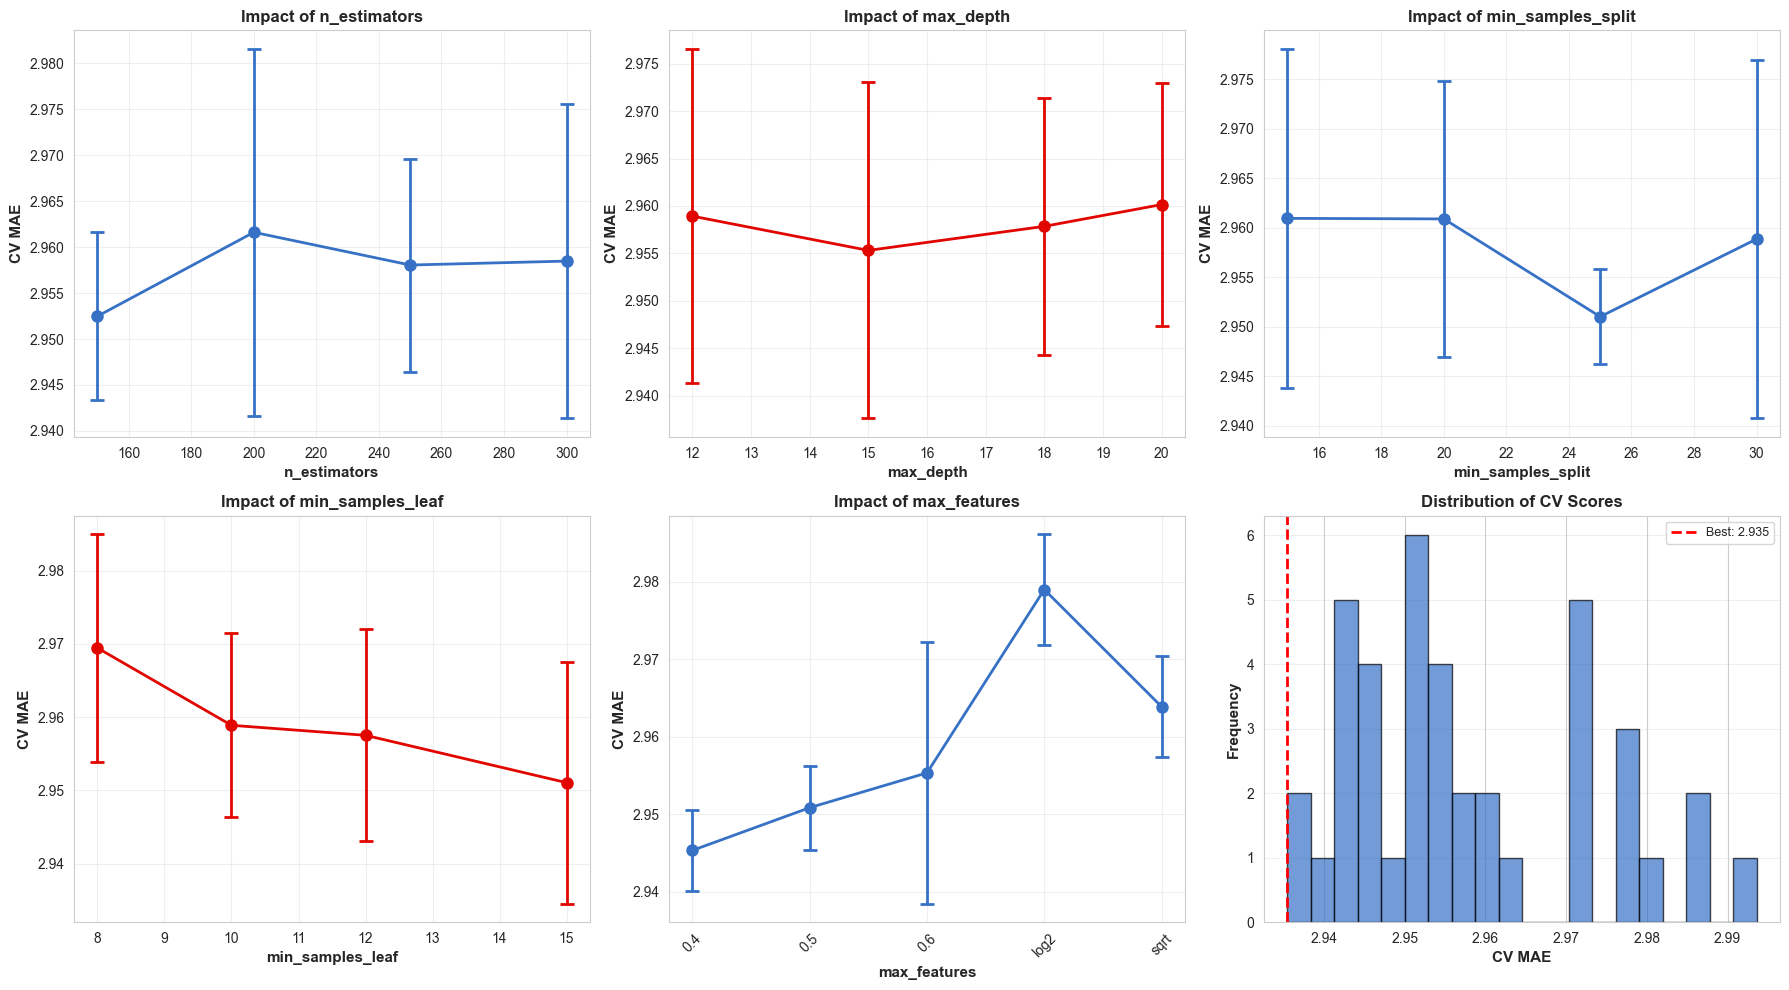

 Hyperparameter analysis complete!


In [11]:
cv_results = optimized_results['cv_results'].sort_values('rank_test_score')

print("\n TOP 10 PARAMETER COMBINATIONS:\n")
print(f"{'Rank':<6} {'CV MAE':<10} {'Std':<10} {'Key Parameters'}")
print("-" * 80)

for idx, row in cv_results.head(10).iterrows():
    rank = int(row['rank_test_score'])
    mae = -row['mean_test_score']
    std = row['std_test_score']
    
    params_str = f"n_est={row['param_n_estimators']}, depth={row['param_max_depth']}, " \
                 f"split={row['param_min_samples_split']}"
    
    print(f"{rank:<6} {mae:<10.3f} {std:<10.3f} {params_str}")


fig, axes = plt.subplots(2, 3, figsize=(18, 10))


param = 'param_n_estimators'
if param in cv_results.columns:
    grouped = cv_results.groupby(param)['mean_test_score'].agg(['mean', 'std'])
    grouped = grouped.sort_index()
    axes[0, 0].errorbar(grouped.index, -grouped['mean'], yerr=grouped['std'], 
                        marker='o', capsize=5, capthick=2, linewidth=2, markersize=8, color='#3671C6')
    axes[0, 0].set_xlabel('n_estimators', fontsize=11, fontweight='bold')
    axes[0, 0].set_ylabel('CV MAE', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Impact of n_estimators', fontweight='bold', fontsize=12)
    axes[0, 0].grid(alpha=0.3)


param = 'param_max_depth'
if param in cv_results.columns:
    grouped = cv_results.groupby(param)['mean_test_score'].agg(['mean', 'std'])
    grouped = grouped.sort_index()
    axes[0, 1].errorbar(grouped.index, -grouped['mean'], yerr=grouped['std'], 
                        marker='o', capsize=5, capthick=2, linewidth=2, markersize=8, color='#E10600')
    axes[0, 1].set_xlabel('max_depth', fontsize=11, fontweight='bold')
    axes[0, 1].set_ylabel('CV MAE', fontsize=11, fontweight='bold')
    axes[0, 1].set_title('Impact of max_depth', fontweight='bold', fontsize=12)
    axes[0, 1].grid(alpha=0.3)


param = 'param_min_samples_split'
if param in cv_results.columns:
    grouped = cv_results.groupby(param)['mean_test_score'].agg(['mean', 'std'])
    grouped = grouped.sort_index()
    axes[0, 2].errorbar(grouped.index, -grouped['mean'], yerr=grouped['std'], 
                        marker='o', capsize=5, capthick=2, linewidth=2, markersize=8, color='#3671C6')
    axes[0, 2].set_xlabel('min_samples_split', fontsize=11, fontweight='bold')
    axes[0, 2].set_ylabel('CV MAE', fontsize=11, fontweight='bold')
    axes[0, 2].set_title('Impact of min_samples_split', fontweight='bold', fontsize=12)
    axes[0, 2].grid(alpha=0.3)


param = 'param_min_samples_leaf'
if param in cv_results.columns:
    grouped = cv_results.groupby(param)['mean_test_score'].agg(['mean', 'std'])
    grouped = grouped.sort_index()
    axes[1, 0].errorbar(grouped.index, -grouped['mean'], yerr=grouped['std'], 
                        marker='o', capsize=5, capthick=2, linewidth=2, markersize=8, color='#E10600')
    axes[1, 0].set_xlabel('min_samples_leaf', fontsize=11, fontweight='bold')
    axes[1, 0].set_ylabel('CV MAE', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Impact of min_samples_leaf', fontweight='bold', fontsize=12)
    axes[1, 0].grid(alpha=0.3)


param = 'param_max_features'
if param in cv_results.columns:
    grouped = cv_results.groupby(param)['mean_test_score'].agg(['mean', 'std'])
    grouped.index = grouped.index.astype(str)
    grouped = grouped.sort_index()
    x_pos = range(len(grouped))
    axes[1, 1].errorbar(x_pos, -grouped['mean'], yerr=grouped['std'], 
                        marker='o', capsize=5, capthick=2, linewidth=2, markersize=8, color='#3671C6')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(grouped.index, rotation=45)
    axes[1, 1].set_xlabel('max_features', fontsize=11, fontweight='bold')
    axes[1, 1].set_ylabel('CV MAE', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Impact of max_features', fontweight='bold', fontsize=12)
    axes[1, 1].grid(alpha=0.3)


axes[1, 2].hist(-cv_results['mean_test_score'], bins=20, color='#3671C6', 
                edgecolor='black', alpha=0.7)
axes[1, 2].axvline(-random_search.best_score_, color='red', linestyle='--', 
                   linewidth=2, label=f'Best: {-random_search.best_score_:.3f}')
axes[1, 2].set_xlabel('CV MAE', fontsize=11, fontweight='bold')
axes[1, 2].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 2].set_title('Distribution of CV Scores', fontweight='bold', fontsize=12)
axes[1, 2].legend(fontsize=9)
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(" Hyperparameter analysis complete!")

## Step 12 : Feature Importance


🏆 FEATURE IMPORTANCE ANALYSIS

🏆 TOP 20 MOST IMPORTANT FEATURES (Optimized model):

quali_position                      ██████████████████████████████████████████ 0.2849
weighted_points_5                   █████████████████████████ 0.1686
grid_position                       ██████████████ 0.0976
driver_id                           ██████████████ 0.0947
q3_gap_to_pole                      ██████████ 0.0671
avg_quali_position_5                █████ 0.0391
team_weighted_points_5              ████ 0.0277
championship_position_before_race   ███ 0.0244
weighted_avg_position_5             ███ 0.0228
recent_form_3                       ███ 0.0204
weighted_podium_rate_5              ███ 0.0204
team_id                             ███ 0.0201
driver_circuit_weighted_pos         ██ 0.0158
driver_circuit_weighted_points      ██ 0.0157
team_weighted_avg_position_5        ██ 0.0147
points_to_leader                    ██ 0.0145
circuit_encoded                     █ 0.0097
quali_gap_to_teammate        

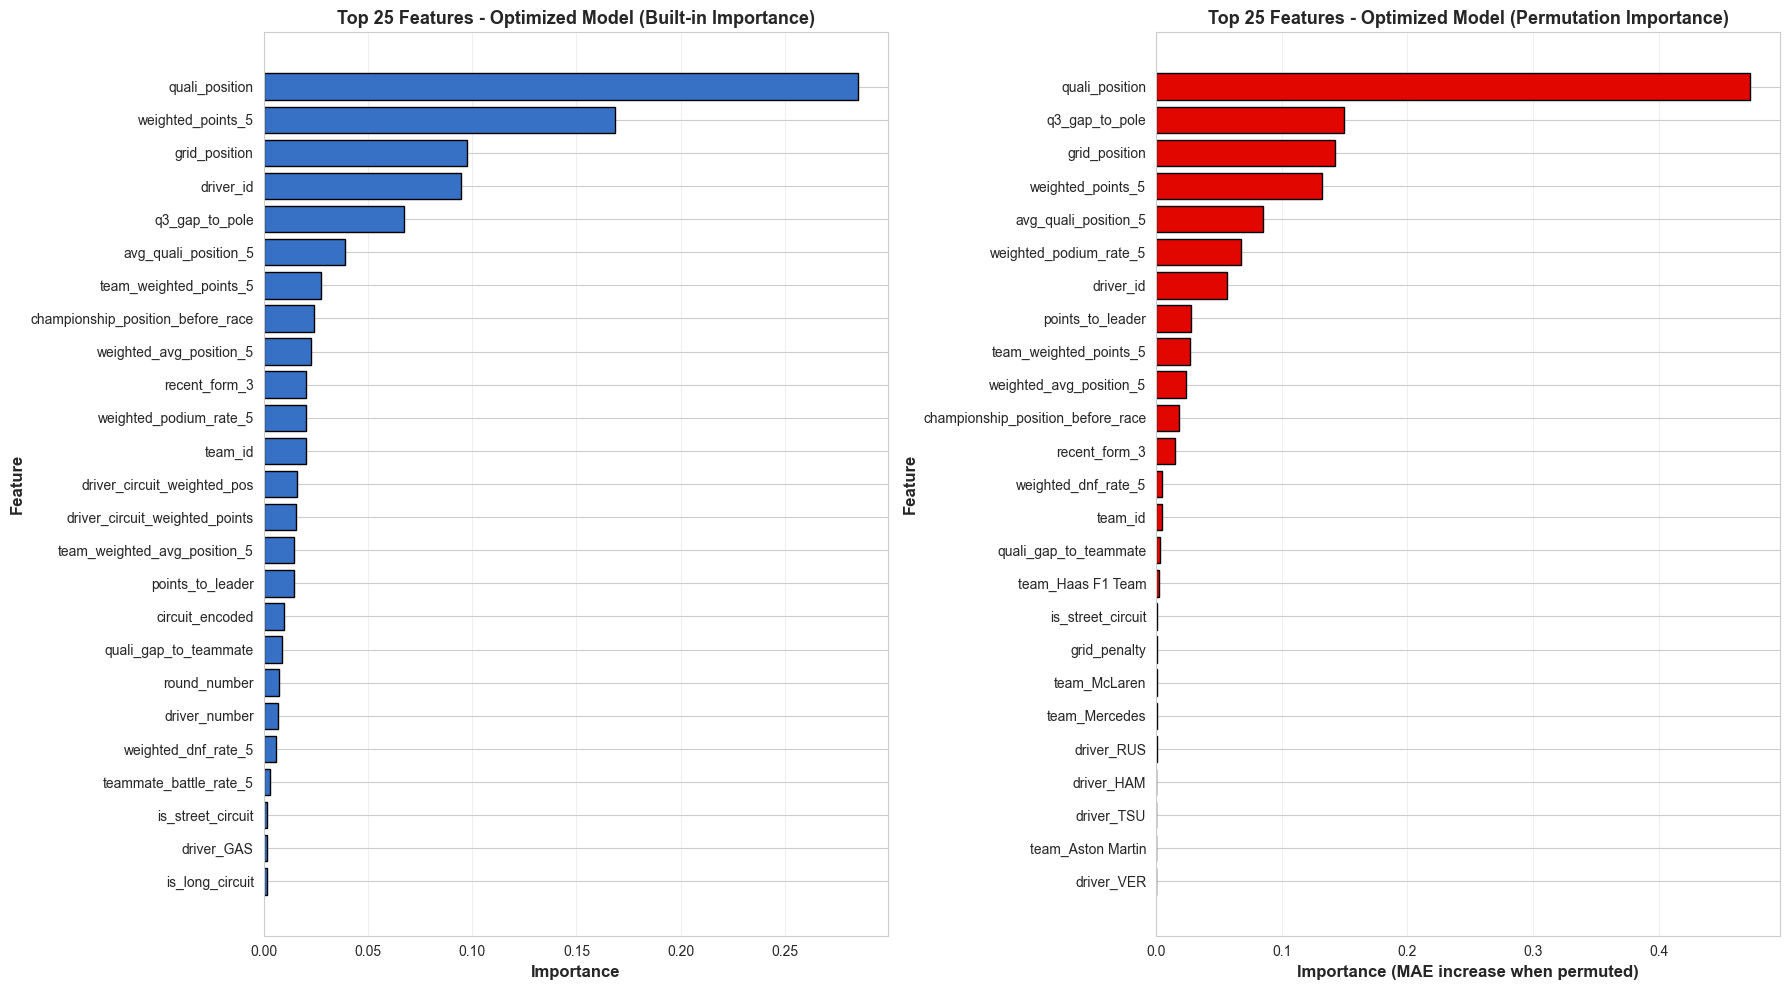


✅ Feature importance analysis complete!

🔍 Top 10 Features Comparison:
Built-in Importance                      Permutation Importance                  
--------------------------------------------------------------------------------
quali_position                           quali_position                          
weighted_points_5                        q3_gap_to_pole                          
grid_position                            grid_position                           
driver_id                                weighted_points_5                       
q3_gap_to_pole                           avg_quali_position_5                    
avg_quali_position_5                     weighted_podium_rate_5                  
team_weighted_points_5                   driver_id                               
championship_position_before_race        points_to_leader                        
weighted_avg_position_5                  team_weighted_points_5                  
recent_form_3              

In [12]:
print("\n" + "="*80)
print("🏆 FEATURE IMPORTANCE ANALYSIS")
print("="*80)


feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🏆 TOP 20 MOST IMPORTANT FEATURES ({best_model_name} model):\n")
for idx, row in feature_importance.head(20).iterrows():
    bar = '█' * int(row['importance'] * 150)
    print(f"{row['feature'][:35]:35s} {bar} {row['importance']:.4f}")


fig, axes = plt.subplots(1, 2, figsize=(18, 10))


top_features = feature_importance.head(25)
axes[0].barh(range(len(top_features)), top_features['importance'], color='#3671C6', edgecolor='black')
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['feature'])
axes[0].set_xlabel('Importance', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Feature', fontsize=12, fontweight='bold')
axes[0].set_title(f'Top 25 Features - {best_model_name} Model (Built-in Importance)', 
                  fontweight='bold', fontsize=13)
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)


print("\n🔄 Computing permutation importance (more reliable)...")
perm_importance = permutation_importance(
    best_model, X_test, y_test, 
    n_repeats=10, random_state=42, n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

perm_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': perm_importance.importances_mean
}).sort_values('importance', ascending=False)

top_perm_features = perm_importance_df.head(25)
axes[1].barh(range(len(top_perm_features)), top_perm_features['importance'], 
             color='#E10600', edgecolor='black')
axes[1].set_yticks(range(len(top_perm_features)))
axes[1].set_yticklabels(top_perm_features['feature'])
axes[1].set_xlabel('Importance (MAE increase when permuted)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Feature', fontsize=12, fontweight='bold')
axes[1].set_title(f'Top 25 Features - {best_model_name} Model (Permutation Importance)', 
                  fontweight='bold', fontsize=13)
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Feature importance analysis complete!")


print("\n🔍 Top 10 Features Comparison:")
print(f"{'Built-in Importance':<40} {'Permutation Importance':<40}")
print("-" * 80)
for i in range(10):
    builtin = feature_importance.iloc[i]['feature']
    perm = perm_importance_df.iloc[i]['feature']
    print(f"{builtin:<40} {perm:<40}")

## Step 13 : Saving

In [13]:
os.makedirs('../models', exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

print("\n" + "="*80)
print("💾 SAVING BEST REGRESSION MODEL")
print("="*80)


model_path = f'../models/RF_Regressor_Position_{best_model_name}_v2_{timestamp}.pkl'
joblib.dump(best_model, model_path)
print(f"\n✅ Model saved: {model_path}")


metadata_dict = {
    'timestamp': datetime.now().isoformat(),
    'version': 'v2_improved_regression',
    'model_type': f'RandomForestRegressor_{best_model_name}',
    'target': 'position',
    'features': feature_cols,
    'n_features': len(feature_cols),
    'baseline_metrics': {
        'train': {k: float(v) for k, v in baseline_train_metrics.items()},
        'test': {k: float(v) for k, v in baseline_test_metrics.items()}
    },
    'optimized_metrics': {
        'train': {k: float(v) for k, v in optimized_train_metrics.items()},
        'test': {k: float(v) for k, v in optimized_test_metrics.items()}
    },
    'best_model_metrics': {
        'train': {k: float(v) for k, v in best_results['train_metrics'].items()},
        'test': {k: float(v) for k, v in best_results['test_metrics'].items()}
    },
    'best_params': {k: (str(v) if v is None else float(v) if isinstance(v, (int, float)) else v) 
                    for k, v in best_results['params'].items()},
    'cv_best_score': float(-random_search.best_score_),
    'improvement_vs_baseline': {
        'mae_improvement_pct': float(mae_improvement),
        'r2_improvement_pct': float(r2_improvement),
        'within2_improvement_pp': float(within2_improvement)
    },
    'top_10_features': feature_importance.head(10)['feature'].tolist(),
    'top_10_features_permutation': perm_importance_df.head(10)['feature'].tolist()
}

metadata_path = f'../models/RF_Regressor_Position_{best_model_name}_v2_{timestamp}_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata_dict, f, indent=2)
print(f"✅ Metadata saved: {metadata_path}")


comparison_path = f'../models/RF_Regression_Comparison_v2_{timestamp}.csv'
comparison_df.to_csv(comparison_path, index=False)
print(f"✅ Comparison saved: {comparison_path}")


cv_results_path = f'../models/RF_Regression_CV_Results_v2_{timestamp}.csv'
cv_results.to_csv(cv_results_path, index=False)
print(f"✅ CV results saved: {cv_results_path}")

saved_files = [model_path, metadata_path, comparison_path, cv_results_path]
print(f"\n✅ All files saved! Total: {len(saved_files)} files")


💾 SAVING BEST REGRESSION MODEL

✅ Model saved: ../models/RF_Regressor_Position_Optimized_v2_20251102_220159.pkl
✅ Metadata saved: ../models/RF_Regressor_Position_Optimized_v2_20251102_220159_metadata.json
✅ Comparison saved: ../models/RF_Regression_Comparison_v2_20251102_220159.csv
✅ CV results saved: ../models/RF_Regression_CV_Results_v2_20251102_220159.csv

✅ All files saved! Total: 4 files


# Final Summary

In [14]:
print("\n" + "="*80)
print(" RANDOM FOREST REGRESSION - FINAL SUMMARY")
print("="*80)

print(f"\n BEST MODEL: {best_model_name.upper()}")
print("-" * 80)
print(f"   Test MAE:       {best_results['test_metrics']['MAE']:.3f} positions ")
print(f"   Test RMSE:      {best_results['test_metrics']['RMSE']:.3f} positions")
print(f"   Test R²:        {best_results['test_metrics']['R2']:.3f}")
print(f"   Median Error:   {best_results['test_metrics']['Median_AE']:.3f} positions")

print(f"\n PREDICTION ACCURACY (Test 2025):")
print(f"   Within 1 position:  {best_results['test_metrics']['Within_1']:.1f}%")
print(f"   Within 2 positions: {best_results['test_metrics']['Within_2']:.1f}% ")
print(f"   Within 3 positions: {best_results['test_metrics']['Within_3']:.1f}%")
print(f"   Within 5 positions: {best_results['test_metrics']['Within_5']:.1f}%")

if best_model_name == "Optimized":
    print(f"\n IMPROVEMENTS OVER BASELINE:")
    print(f"   MAE improved by:  {mae_improvement:+.1f}%")
    print(f"   R² improved by:   {r2_improvement:+.1f}%")
    print(f"   Within 2 improved: {within2_improvement:+.1f} percentage points")

print(f"\n TOP 5 MOST IMPORTANT FEATURES:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"   {idx+1}. {row['feature']} ({row['importance']:.4f})")

print(f"\n MODEL CHARACTERISTICS:")
print(f"   Trees: {best_results['params']['n_estimators']}")
print(f"   Max depth: {best_results['params']['max_depth']}")
print(f"   Min samples split: {best_results['params']['min_samples_split']}")
print(f"   Min samples leaf: {best_results['params']['min_samples_leaf']}")

#print(f"\n💾 SAVED FILES:")
#for file in saved_files:
#    print(f"   {file}")

print(f"\n💡 PERFORMANCE EVALUATION:")
if best_results['test_metrics']['MAE'] < 2.0:
    print("   ✅ EXCELLENT! Model achieves professional-grade accuracy")
    print("   📊 Predictions typically within 2 positions")
elif best_results['test_metrics']['MAE'] < 2.5:
    print("   ✅ VERY GOOD! Strong predictive performance")
    print("   📊 Competitive with industry standards")
elif best_results['test_metrics']['MAE'] < 3.0:
    print("   ✅ GOOD! Solid baseline performance")
    print("   📊 Consider gradient boosting for further improvements")
else:
    print("   ⚠️  FAIR - Room for improvement")


print("\n" + "="*80)
print("🎉 Random Forest regression training complete!")
print("="*80)


 RANDOM FOREST REGRESSION - FINAL SUMMARY

 BEST MODEL: OPTIMIZED
--------------------------------------------------------------------------------
   Test MAE:       3.191 positions 
   Test RMSE:      4.175 positions
   Test R²:        0.469
   Median Error:   2.346 positions

 PREDICTION ACCURACY (Test 2025):
   Within 1 position:  17.1%
   Within 2 positions: 41.3% 
   Within 3 positions: 61.3%
   Within 5 positions: 81.8%

 IMPROVEMENTS OVER BASELINE:
   MAE improved by:  +0.8%
   R² improved by:   +0.5%
   Within 2 improved: +1.3 percentage points

 TOP 5 MOST IMPORTANT FEATURES:
   2. quali_position (0.2849)
   13. weighted_points_5 (0.1686)
   1. grid_position (0.0976)
   25. driver_id (0.0947)
   7. q3_gap_to_pole (0.0671)

 MODEL CHARACTERISTICS:
   Trees: 200
   Max depth: 12
   Min samples split: 30
   Min samples leaf: 15

💡 PERFORMANCE EVALUATION:
   ⚠️  FAIR - Room for improvement

🎉 Random Forest regression training complete!
